In [1]:
import pandas as pd
import numpy as np
#import glob

import matplotlib.pyplot as plt
import numpy
import seaborn as sns


from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import scipy.cluster.hierarchy as hca

import warnings
warnings.filterwarnings("ignore")

# Predprocesiranje

In [2]:
# Ucitavamo tabele i ispisujemo broj redova i kolona

accidents = pd.read_csv('Accident_Information.csv')
print('Accidents:\n','Records:', accidents.shape[0], '\nColumns:', accidents.shape[1])

vehicles = pd.read_csv('Vehicle_Information.csv', encoding='ISO-8859-1')
print('Vehicles:\n','Records:', vehicles.shape[0], '\nColumns:', vehicles.shape[1])

#accidents.head()
#vehicles.head()

Accidents:
 Records: 2047256 
Columns: 34
Vehicles:
 Records: 2177205 
Columns: 24


In [3]:
# Informacije o tipovima


#print(accidents.dtypes)

#print('\n')

#print(vehicles.dtypes)



In [4]:
# Ovaj deo je preuzet kao ideja iz kaggle kernela za ovaj dataset:
# https://www.kaggle.com/brittabettendorf/visual-analysis-eda
# sa istog mesta preuzete su prve 3 vizualizacije ispod

accidents['Date']= pd.to_datetime(accidents['Date'], format="%Y-%m-%d")

# slice first and second string from time column
accidents['Hour'] = accidents['Time'].str[0:2]

# convert new column to numeric datetype
accidents['Hour'] = pd.to_numeric(accidents['Hour'])

# drop null values in our new column
accidents = accidents.dropna(subset=['Hour'])

# cast to integer values
accidents['Hour'] = accidents['Hour'].astype('int')


def when_was_it(hour):
    if hour >= 5 and hour < 10:
        return "morning rush (5-10)"
    elif hour >= 10 and hour < 15:
        return "office hours (10-15)"
    elif hour >= 15 and hour < 19:
        return "afternoon rush (15-19)"
    elif hour >= 19 and hour < 23:
        return "evening (19-23)"
    else:
        return "night (23-5)"
    
# apply thus function to our temporary hour column
accidents['Daytime'] = accidents['Hour'].apply(when_was_it)
accidents[['Time', 'Hour', 'Daytime']].head(8)

# drop old time column and temporary hour column
#accidents = accidents.drop(columns=['Time', 'Hour'])

,Time,Hour,Daytime
0,17:42,17,afternoon rush (15-19)
1,17:36,17,afternoon rush (15-19)
2,00:15,0,night (23-5)
3,10:35,10,office hours (10-15)
4,21:13,21,evening (19-23)
5,12:40,12,office hours (10-15)
6,20:40,20,evening (19-23)
7,17:35,17,afternoon rush (15-19)


In [5]:
# Odbacivanje kolona koje imaju previse nedostajucih(nan, null, zabelezeno da nije zabelezeno) vrednosti
# ili prvobitnom analizom vidimo da nisu od interesa

accidents_dr = accidents.drop(['Carriageway_Hazards',
                              'LSOA_of_Accident_Location',
                              'Pedestrian_Crossing-Human_Control',
                              'Pedestrian_Crossing-Physical_Facilities',
                               '1st_Road_Number',
                               '2nd_Road_Number',
                               'Location_Easting_OSGR',
                               'Location_Northing_OSGR', 
                               'Time',  'Year',
                               '2nd_Road_Class',
                               
                               'Day_of_Week',
                               'Urban_or_Rural_Area'
                               
                                 ], axis=1)


vehicles_dr = vehicles.drop(['Driver_IMD_Decile',
                             'Age_of_Vehicle', 
                             'Engine_Capacity_.CC.', 
                             'make',
                             'model',
                             'Propulsion_Code',
                             'Vehicle_Location.Restricted_Lane',
                             'Hit_Object_in_Carriageway',
                             'Hit_Object_off_Carriageway',
                             'Propulsion_Code',
                             'Skidding_and_Overturning',
                             'Towing_and_Articulation',
                             'Year',
                             'Vehicle_Reference',
                             'Journey_Purpose_of_Driver',
                             'Was_Vehicle_Left_Hand_Drive'
                             
                               ], axis=1) 



In [6]:
# Ostale nedostajuce vrednosi
# Pre ovoga smo svakako odbacili kolone sa previse nedostajucih vrednosti
# I prilozenim slikama (NA1.png, NA2.png) u ovom folderu mozemo videti 
# da se u ostalim kolonama ne nalazi mnogo redova koje sadrze nedostajuce vrednosti 
# tako da uklanjanjem celih redova necemo puno ostetiti bazu


accidents_na = accidents_dr.replace('?', np.nan)
accidents_na = accidents_na.replace('Data missing or out of range', np.nan)

accidents_na = accidents_na.dropna()



vehicles_na = vehicles_dr.replace('?', np.nan)
vehicles_na = vehicles_na.replace('Data missing or out of range', np.nan)

vehicles_na = vehicles_na.dropna()



In [7]:
# Uvid u redukciju skupa podataka za sad

print('Records:', vehicles_na.shape[0], '\nColumns:', vehicles_na.shape[1])
print('Records:', accidents_na.shape[0], '\nColumns:', accidents_na.shape[1])

Records: 1707518 
Columns: 9
Records: 1289781 
Columns: 23


In [134]:
# Spajanje tabela accidents i vehicles na osnovu zajednicke kolone koja ih indeksira

df = pd.merge(vehicles_na, accidents_na, how = 'inner', on = 'Accident_Index')



df.drop(['Accident_Index'], axis=1, inplace=True) 
print(df.shape)

# prep1.csv => dataset bez nebitnih kolona i nedostajucih vrednosti
df.to_csv('prep1.csv')

(1088249, 30)


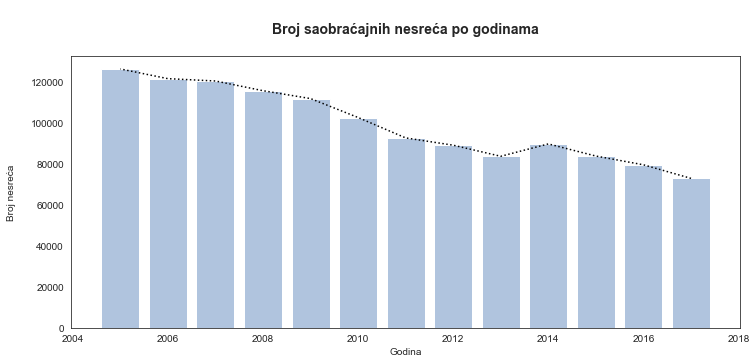

In [135]:
#koristimo stari dataframe accidents_na jer pri spajanju sa tabelom o vozilima gubimo informacije iz 2017. godine
yearly_count = accidents_na['Date'].dt.year.value_counts().sort_index(ascending=False)


sns.set_style('white')
fig, ax = plt.subplots(figsize=(12,5))


ax.bar(yearly_count.index, yearly_count.values, color='lightsteelblue')
ax.plot(yearly_count, linestyle=':', color='black')
ax.set_title('\nBroj saobraćajnih nesreća po godinama\n', fontsize=14, fontweight='bold')
ax.set(xlabel='Godina',ylabel='Broj nesreća\n');
plt.savefig("viz1.png")
plt.savefig("viz1.svg")
#sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);



In [136]:
weekday_counts = pd.DataFrame(accidents.set_index('Date').resample('1d')['Accident_Index'].size().reset_index())
weekday_counts.columns = ['Date', 'Count']
#weekday_counts

weekday = weekday_counts['Date'].dt.weekday_name
#weekday

weekday_averages = pd.DataFrame(weekday_counts.groupby(weekday)['Count'].mean().reset_index())
weekday_averages.columns = ['Weekday', 'Average_Accidents']
weekday_averages.set_index('Weekday', inplace=True)
weekday_averages




,Average_Accidents
Weekday,
Friday,494.345133
Monday,428.410029
Saturday,402.254786
Sunday,331.821797
Thursday,454.595870
Tuesday,451.721239
Wednesday,455.089971


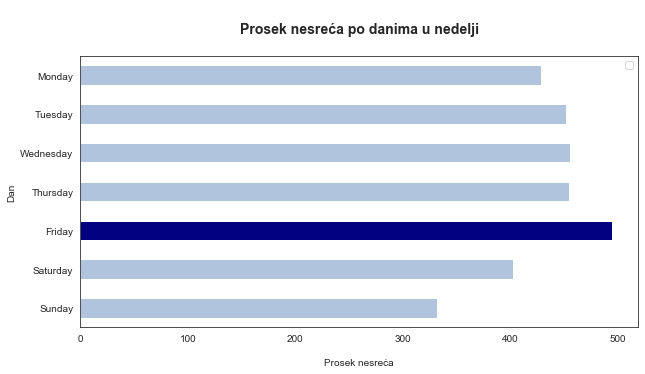

In [137]:
# reorder the weekdays beginning with Monday (backwards because of printing behavior!)
days = ['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']

# prepare plot
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10,5))
colors=['lightsteelblue', 'lightsteelblue', 'navy', 'lightsteelblue', 
        'lightsteelblue', 'lightsteelblue', 'lightsteelblue']

# plot
weekday_averages.reindex(days).plot(kind='barh', ax=ax, color=[colors])
ax.set_title('\nProsek nesreća po danima u nedelji\n', fontsize=14, fontweight='bold')
ax.set(xlabel='\nProsek nesreća', ylabel='Dan')
ax.legend('')

plt.savefig("viz2.png")
plt.savefig("viz2.svg")
df.drop(['Date'],  axis=1, inplace=True)

# remove all spines
#sns.despine(ax=ax, top=True, right=True, left=True, bottom=True);

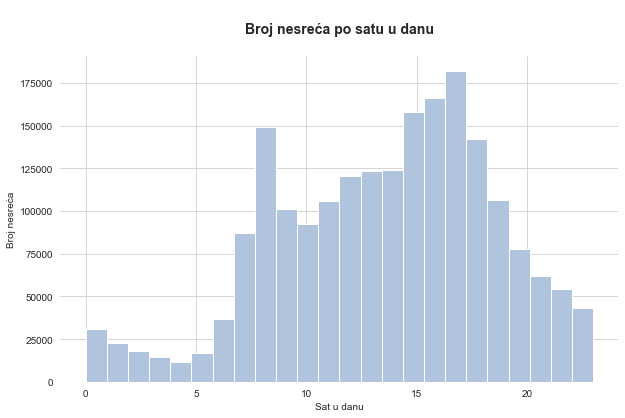

In [138]:
# prepare plot
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10,6))

# plot
accidents.Hour.hist(bins=24, ax=ax, color='lightsteelblue')
ax.set_title('\nBroj nesreća po satu u danu\n', fontsize=14, fontweight='bold')
ax.set(xlabel='Sat u danu', ylabel='Broj nesreća')

# remove all spines
sns.despine(top=True, right=True, left=True, bottom=True);

df.drop(['Hour'],  axis=1, inplace=True)
plt.savefig("viz3.png")
plt.savefig("viz3.svg")

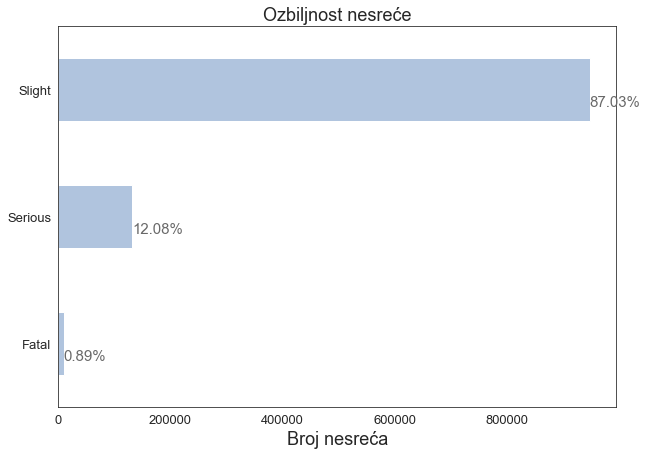

In [139]:
ax = df['Accident_Severity'].value_counts().plot(kind='barh', figsize=(10,7),
                                        color="lightsteelblue", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Ozbiljnost nesreće", fontsize=18)
ax.set_xlabel("Broj nesreća", fontsize=18);
#ax.set_xticks([0, 200000, 400000, 600000, 800000])

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
color='dimgrey')

# invert for largest on top 
ax.invert_yaxis()
plt.savefig("viz4.png")
plt.savefig("viz4.svg")

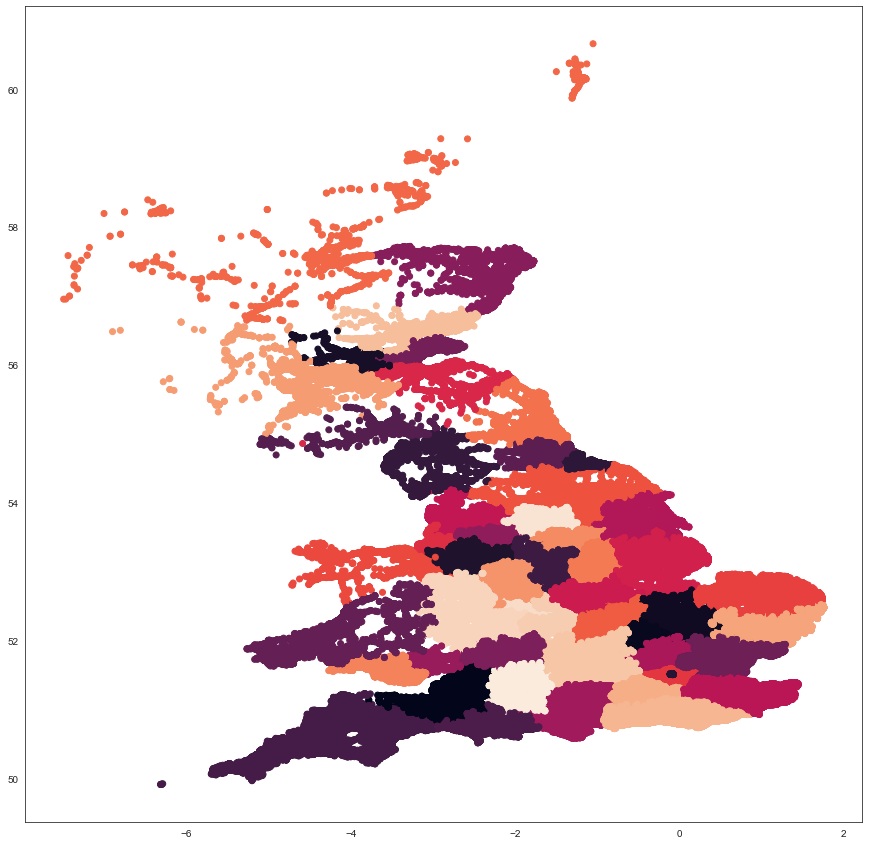

In [140]:
# koristimo podatke o geografskoj duzini i sirini da bismo napravili vizuelizaciju prostora delovanja razlicitih
# policijskih snaga

df["Police_Force"] = df["Police_Force"].astype('category')
df["Police_Force"] = df["Police_Force"].cat.codes

plt.figure(figsize=(15, 15))
plt.scatter(df.Longitude,df.Latitude,c = df.Police_Force)
plt.savefig("viz5.png")
plt.savefig("viz5.svg")
plt.show()



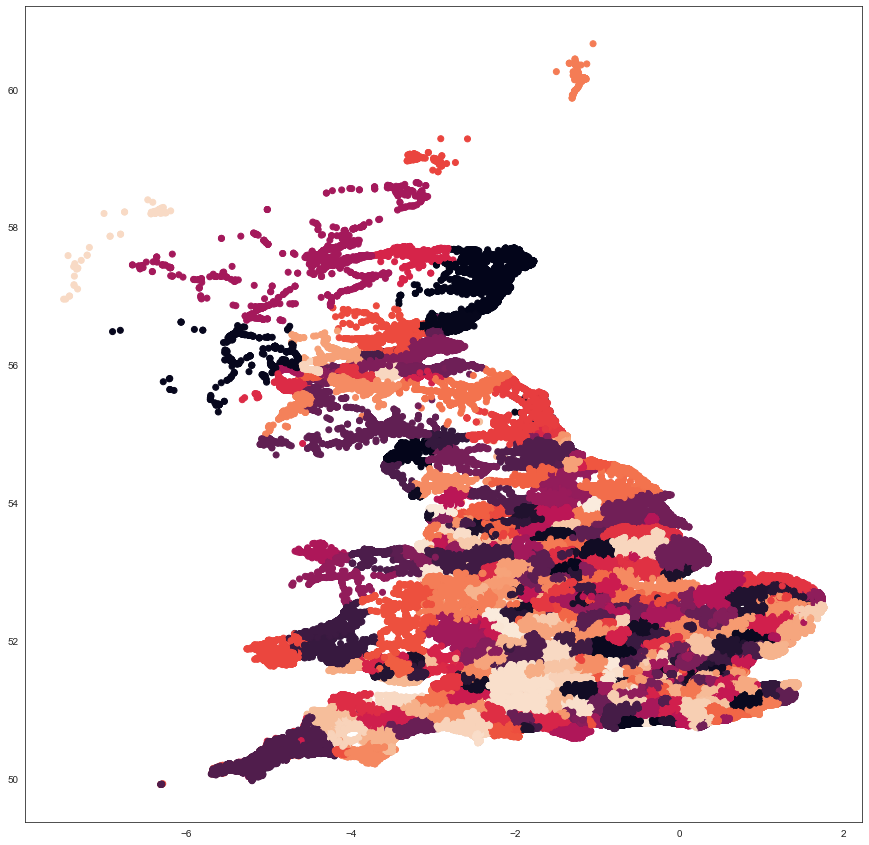

In [141]:
# koristimo podatke o geografskoj duzini i sirini da bismo napravili vizuelizaciju prostora delovanja razlicitih
# lokalnih vlasti za distrikte

df["Local_Authority_(District)"] = df["Local_Authority_(District)"].astype('category')
df["Local_Authority_(District)"] = df["Local_Authority_(District)"].cat.codes

plt.figure(figsize=(15, 15))
plt.scatter(df.Longitude,df.Latitude,c = df['Local_Authority_(District)'])
plt.savefig("viz6.png")
plt.savefig("viz6.svg")
plt.show()


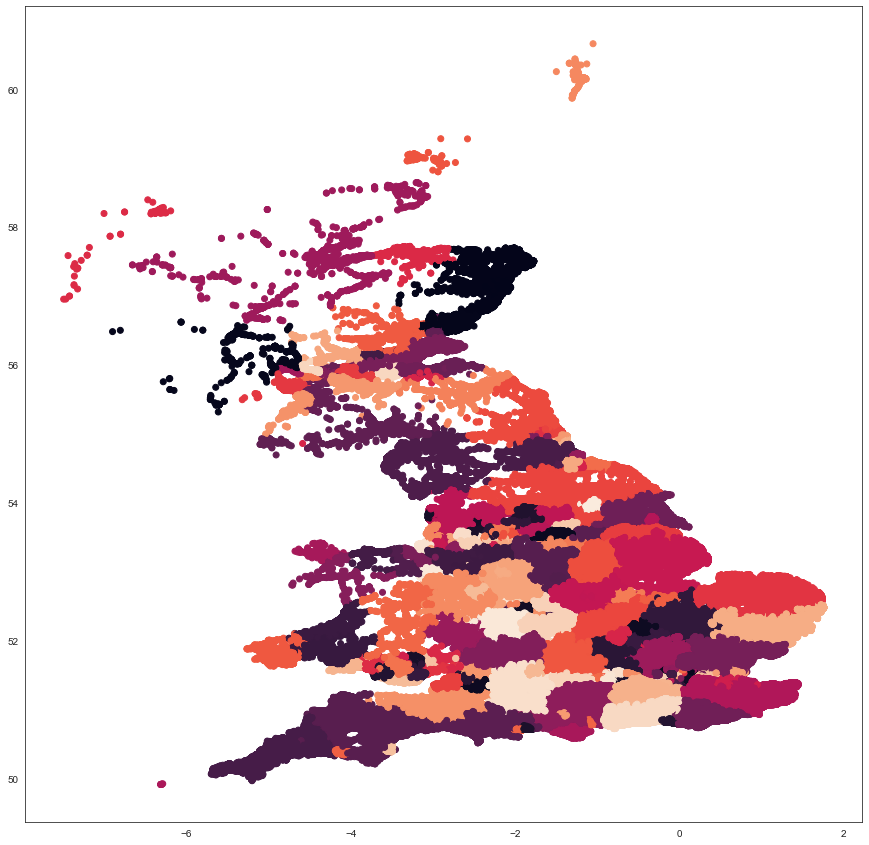

In [142]:
# koristimo podatke o geografskoj duzini i sirini da bismo napravili vizuelizaciju prostora delovanja razlicitih
# lokalnih vlasti za autoputeve

df["Local_Authority_(Highway)"] = df["Local_Authority_(Highway)"].astype('category')
df["Local_Authority_(Highway)"] = df["Local_Authority_(Highway)"].cat.codes

plt.figure(figsize=(15, 15))
plt.scatter(df.Longitude,df.Latitude,c = df['Local_Authority_(Highway)'])
plt.savefig("viz7.png")
plt.savefig("viz7.svg")
plt.show()



In [143]:
# prebacujemo u numericke one atribute koji su binarni ili razmerni

cleanup_map = {"InScotland":                {'No': 0, 'Yes': 1},
               
               "Age_Band_of_Driver":        {'36 - 45': 2, '26 - 35': 2,
                                             '56 - 65': 3, '46 - 55': 2,
                                             '21 - 25': 1, '16 - 20': 1,
                                             '66 - 75': 3, 'Over 75': 3,
                                             '11 - 15': 0, '6 - 10' : 0, '0 - 5':0} ,
               
               "Accident_Severity":         {'Slight':0, 'Serious':1, 'Fatal':2},
               
               
               "Light_Conditions":          { 'Darkness - lights lit':1, 'Daylight':0, 'Darkness - lights unlit':1.5,
                                             'Darkness - lighting unknown':1.25, 'Darkness - no lighting':2},
               
               "1st_Road_Class":            {'C':0, 'A':2, 'B': 1, 'Unclassified':0.5, 'Motorway':3, 'A(M)':2.5},
               
               "Daytime":                   {'evening (19-23)':3, 'night (23-5)':4, 'morning rush (5-10)':0,
                                             'office hours (10-15)':1, 'afternoon rush (15-19)':2 },
               
               "Sex_of_Driver":             {'Male': 1, 'Female': 0,'Not known': 1},
               
               "Road_Surface_Conditions":   {'Dry': 0, 'Wet or damp': 1,
                                             'Frost or ice': 2, 'Flood over 3cm. deep': 3,
                                             'Snow': 4},
               "Driver_Home_Area_Type":     {'Urban area':2 , 'Rural': 0, 'Small town': 1},
               
               "Weather_Conditions":        {'Fine no high winds': 0,
                                             'Raining no high winds': 1,
                                             'Snowing no high winds': 2,
                                             'Fine + high winds': 0.5,
                                             'Other':0.5,
                                             'Raining + high winds': 1.5,
                                             'Unknown': 0.5,
                                             'Fog or mist': 3.5,
                                             'Snowing + high winds':3},

              
               
               "Vehicle_Type": {'Car' :3,
                                'Bus or coach (17 or more pass seats)': 4,
                                'Motorcycle 125cc and under': 2,
                                'Motorcycle over 125cc and up to 500cc': 2,
                                'Motorcycle over 500cc': 2,
                                'Taxi/Private hire car': 3,
                                'Goods 7.5 tonnes mgw and over': 5,
                                'Van / Goods 3.5 tonnes mgw or under': 4,
                                'Motorcycle 50cc and under': 2,
                                'Goods over 3.5t. and under 7.5t': 5,
                                'Minibus (8 - 16 passenger seats)': 4,
                                'Other vehicle': 3.5,
                                'Agricultural vehicle': 0,
                                'Pedal cycle': 0.5,
                                'Motorcycle - unknown cc': 2,
                                'Mobility scooter': 1.5,
                                'Goods vehicle - unknown weight': 5,
                                'Electric motorcycle': 2,
                                'Tram': 3.5,
                                'Ridden horse': 0
                               }
               
              }






df.replace(cleanup_map, inplace=True)

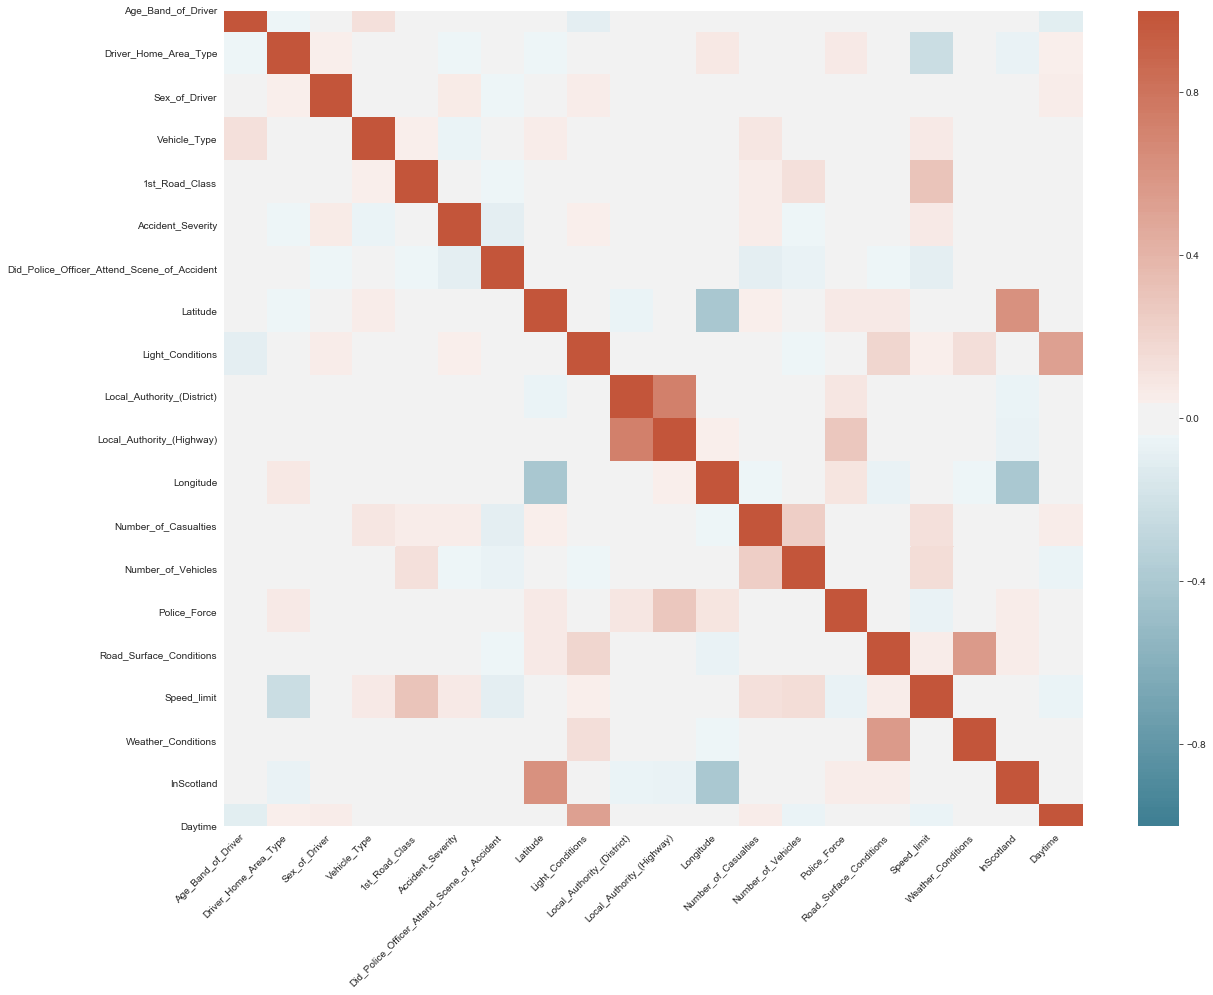

In [144]:
# Matrica korelacije

corr =  df.corr()
plt.subplots(figsize=(20,15))


ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True
)


ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

plt.savefig("mx.png")
plt.savefig("mx.svg")

In [37]:
# Uklanjanje kolona koje su bile potrebne za vizuelizaciju

df.drop(['Police_Force','Local_Authority_(Highway)','Local_Authority_(District)','Longitude','Latitude'], axis=1, inplace=True )

#cuvamo za dalje objedinjavanje ispod
df.to_csv('temp.csv')

# prep2.csv => prep1 + kategoricki atributi medju kojima se moze uspostaviti uredjenje prebaceni u numericke atribute
prep2 = df[[ 'Road_Surface_Conditions', 'Speed_limit', 'InScotland', 'Daytime', 'Age_Band_of_Driver',
            'Driver_Home_Area_Type', 'Sex_of_Driver', 'Vehicle_Type',  '1st_Road_Class',  'Number_of_Casualties',
            'Number_of_Vehicles','Weather_Conditions','Light_Conditions','Accident_Severity']]

prep2.to_csv('prep2.csv')
prep2.head()


,Road_Surface_Conditions,Speed_limit,InScotland,Daytime,Age_Band_of_Driver,Driver_Home_Area_Type,Sex_of_Driver,Vehicle_Type,1st_Road_Class,Number_of_Casualties,Number_of_Vehicles,Weather_Conditions,Light_Conditions,Accident_Severity
0,0,30.0,0,3,2,2,1,3.0,0.0,1,2,0.0,1.0,0
1,0,30.0,0,4,2,2,1,3.0,2.0,1,1,0.0,1.0,0
2,1,30.0,0,0,2,2,1,3.0,2.0,1,2,1.0,1.0,0
3,1,30.0,0,0,2,2,1,3.0,2.0,1,2,1.0,1.0,0
4,0,30.0,0,1,3,2,1,4.0,2.0,1,1,0.0,0.0,0


In [38]:
df = prep2

features = df.columns[:]
scaler = MinMaxScaler().fit(df)
x = pd.DataFrame(scaler.transform(df))
x.columns = features

x.to_csv('prep2minmax.csv')
x.head()

,Road_Surface_Conditions,Speed_limit,InScotland,Daytime,Age_Band_of_Driver,Driver_Home_Area_Type,Sex_of_Driver,Vehicle_Type,1st_Road_Class,Number_of_Casualties,Number_of_Vehicles,Weather_Conditions,Light_Conditions,Accident_Severity
0,0.00,0.333333,0.0,0.75,0.666667,1.0,1.0,0.6,0.000000,0.0,0.032258,0.000000,0.5,0.0
1,0.00,0.333333,0.0,1.00,0.666667,1.0,1.0,0.6,0.666667,0.0,0.000000,0.000000,0.5,0.0
2,0.25,0.333333,0.0,0.00,0.666667,1.0,1.0,0.6,0.666667,0.0,0.032258,0.285714,0.5,0.0
3,0.25,0.333333,0.0,0.00,0.666667,1.0,1.0,0.6,0.666667,0.0,0.032258,0.285714,0.5,0.0
4,0.00,0.333333,0.0,0.25,1.000000,1.0,1.0,0.8,0.666667,0.0,0.000000,0.000000,0.0,0.0


In [39]:
# prebacujemo u numericke one atribute koji su binarni ili razmerni
df = pd.read_csv('prep1.csv')
df = df[['Junction_Control','Junction_Detail','Junction_Location','Special_Conditions_at_Site','Road_Type','Vehicle_Manoeuvre','Vehicle_Leaving_Carriageway','X1st_Point_of_Impact']]


ctg = pd.get_dummies(data=df,columns=df.columns)


#ctg.drop(['Junction_Location','Special_Conditions_at_Site','Road_Type','Vehicle_Manoeuvre','Vehicle_Leaving_Carriageway','X1st_Point_of_Impact'])



In [40]:
ctg = ctg.iloc[:,:]

# prep3 -> samo flag atributi dobijeni iz kategorickih
ctg.to_csv('prep3.csv')

ctg.head()

,Junction_Control_Authorised person,Junction_Control_Auto traffic signal,Junction_Control_Give way or uncontrolled,Junction_Control_Not at junction or within 20 metres,Junction_Control_Stop sign,Junction_Detail_Crossroads,Junction_Detail_Mini-roundabout,Junction_Detail_More than 4 arms (not roundabout),Junction_Detail_Not at junction or within 20 metres,Junction_Detail_Other junction,...,Vehicle_Leaving_Carriageway_Offside - crossed central reservation,Vehicle_Leaving_Carriageway_Offside and rebounded,Vehicle_Leaving_Carriageway_Offside on to central reservation,Vehicle_Leaving_Carriageway_Offside on to centrl res + rebounded,Vehicle_Leaving_Carriageway_Straight ahead at junction,X1st_Point_of_Impact_Back,X1st_Point_of_Impact_Did not impact,X1st_Point_of_Impact_Front,X1st_Point_of_Impact_Nearside,X1st_Point_of_Impact_Offside
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [41]:
df = pd.read_csv('temp.csv')


df2 = df[['Junction_Control','Junction_Detail','Junction_Location','Special_Conditions_at_Site','Road_Type','Vehicle_Manoeuvre','Vehicle_Leaving_Carriageway','X1st_Point_of_Impact']]


ctg2 = pd.get_dummies(data=df,columns=df2.columns)
ctg2.head()


features = ctg2.columns[:]
scaler = MinMaxScaler().fit(ctg2)
x = pd.DataFrame(scaler.transform(ctg2))
x.columns = features

x.to_csv('fullflagprep.csv')
x.head()

,Unnamed: 0,Age_Band_of_Driver,Driver_Home_Area_Type,Sex_of_Driver,Vehicle_Type,1st_Road_Class,Accident_Severity,Did_Police_Officer_Attend_Scene_of_Accident,Light_Conditions,Number_of_Casualties,...,Vehicle_Leaving_Carriageway_Offside - crossed central reservation,Vehicle_Leaving_Carriageway_Offside and rebounded,Vehicle_Leaving_Carriageway_Offside on to central reservation,Vehicle_Leaving_Carriageway_Offside on to centrl res + rebounded,Vehicle_Leaving_Carriageway_Straight ahead at junction,X1st_Point_of_Impact_Back,X1st_Point_of_Impact_Did not impact,X1st_Point_of_Impact_Front,X1st_Point_of_Impact_Nearside,X1st_Point_of_Impact_Offside
0,0.000000e+00,0.666667,1.0,1.0,0.6,0.000000,0.0,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,9.189082e-07,0.666667,1.0,1.0,0.6,0.666667,0.0,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.837816e-06,0.666667,1.0,1.0,0.6,0.666667,0.0,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2.756725e-06,0.666667,1.0,1.0,0.6,0.666667,0.0,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3.675633e-06,1.000000,1.0,1.0,0.8,0.666667,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [42]:
x=x.iloc[:,1:]
x.to_csv('fullflagprep.csv')
x.head()

,Age_Band_of_Driver,Driver_Home_Area_Type,Sex_of_Driver,Vehicle_Type,1st_Road_Class,Accident_Severity,Did_Police_Officer_Attend_Scene_of_Accident,Light_Conditions,Number_of_Casualties,Number_of_Vehicles,...,Vehicle_Leaving_Carriageway_Offside - crossed central reservation,Vehicle_Leaving_Carriageway_Offside and rebounded,Vehicle_Leaving_Carriageway_Offside on to central reservation,Vehicle_Leaving_Carriageway_Offside on to centrl res + rebounded,Vehicle_Leaving_Carriageway_Straight ahead at junction,X1st_Point_of_Impact_Back,X1st_Point_of_Impact_Did not impact,X1st_Point_of_Impact_Front,X1st_Point_of_Impact_Nearside,X1st_Point_of_Impact_Offside
0,0.666667,1.0,1.0,0.6,0.000000,0.0,0.0,0.5,0.0,0.032258,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.666667,1.0,1.0,0.6,0.666667,0.0,0.0,0.5,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.666667,1.0,1.0,0.6,0.666667,0.0,0.0,0.5,0.0,0.032258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.666667,1.0,1.0,0.6,0.666667,0.0,0.0,0.5,0.0,0.032258,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.000000,1.0,1.0,0.8,0.666667,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# K-Means

In [65]:
df_no = pd.read_csv('prep2minmax.csv')

df_f =  pd.read_csv('prep3.csv')

df_nof = pd.read_csv('fullflagprep.csv')

df_c = df_no[['Speed_limit','Number_of_Vehicles','Weather_Conditions', 'Road_Surface_Conditions','Age_Band_of_Driver','Driver_Home_Area_Type','Vehicle_Type']]

In [66]:
df_f = df_f.iloc[:,1:]
df_no = df_no.iloc[:,1:]
df_nof = df_nof.iloc[:,1:]
#df_c = df_no[['Number_of_Vehicles','Weather_Conditions', 'Road_Surface_Conditions','Age_Band_of_Driver','Driver_Home_Area_Type','Vehicle_Type']]

In [132]:
####################################################################################################
#da se ne bi puno ponavljao kod u ovom delu samo za df_scaled menjamo izmedju 4 gore-navedena skupa
####################################################################################################

df_scaled = df_f

#prevelik dataset #BIGDATA haha
df_scaled = df_scaled.sample(frac =.01)
df_scaled.head()

,Junction_Control_Authorised person,Junction_Control_Auto traffic signal,Junction_Control_Give way or uncontrolled,Junction_Control_Not at junction or within 20 metres,Junction_Control_Stop sign,Junction_Detail_Crossroads,Junction_Detail_Mini-roundabout,Junction_Detail_More than 4 arms (not roundabout),Junction_Detail_Not at junction or within 20 metres,Junction_Detail_Other junction,...,Vehicle_Leaving_Carriageway_Offside - crossed central reservation,Vehicle_Leaving_Carriageway_Offside and rebounded,Vehicle_Leaving_Carriageway_Offside on to central reservation,Vehicle_Leaving_Carriageway_Offside on to centrl res + rebounded,Vehicle_Leaving_Carriageway_Straight ahead at junction,X1st_Point_of_Impact_Back,X1st_Point_of_Impact_Did not impact,X1st_Point_of_Impact_Front,X1st_Point_of_Impact_Nearside,X1st_Point_of_Impact_Offside
416994,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
407689,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1053972,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
889059,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
691455,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


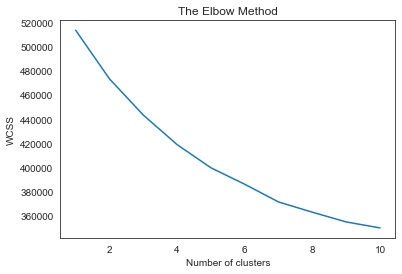

In [123]:
#cluster = df[['Speed_limit','Number_of_Vehicles','Weather_Conditions', 'Road_Surface_Conditions','Age_Band_of_Driver','Driver_Home_Area_Type']]

cluster = df_scaled




df2 = cluster.apply(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)), axis = 0)
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(df2)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

#plt.savefig("elbow_.png")
#plt.savefig("elbow_.svg")
plt.show()


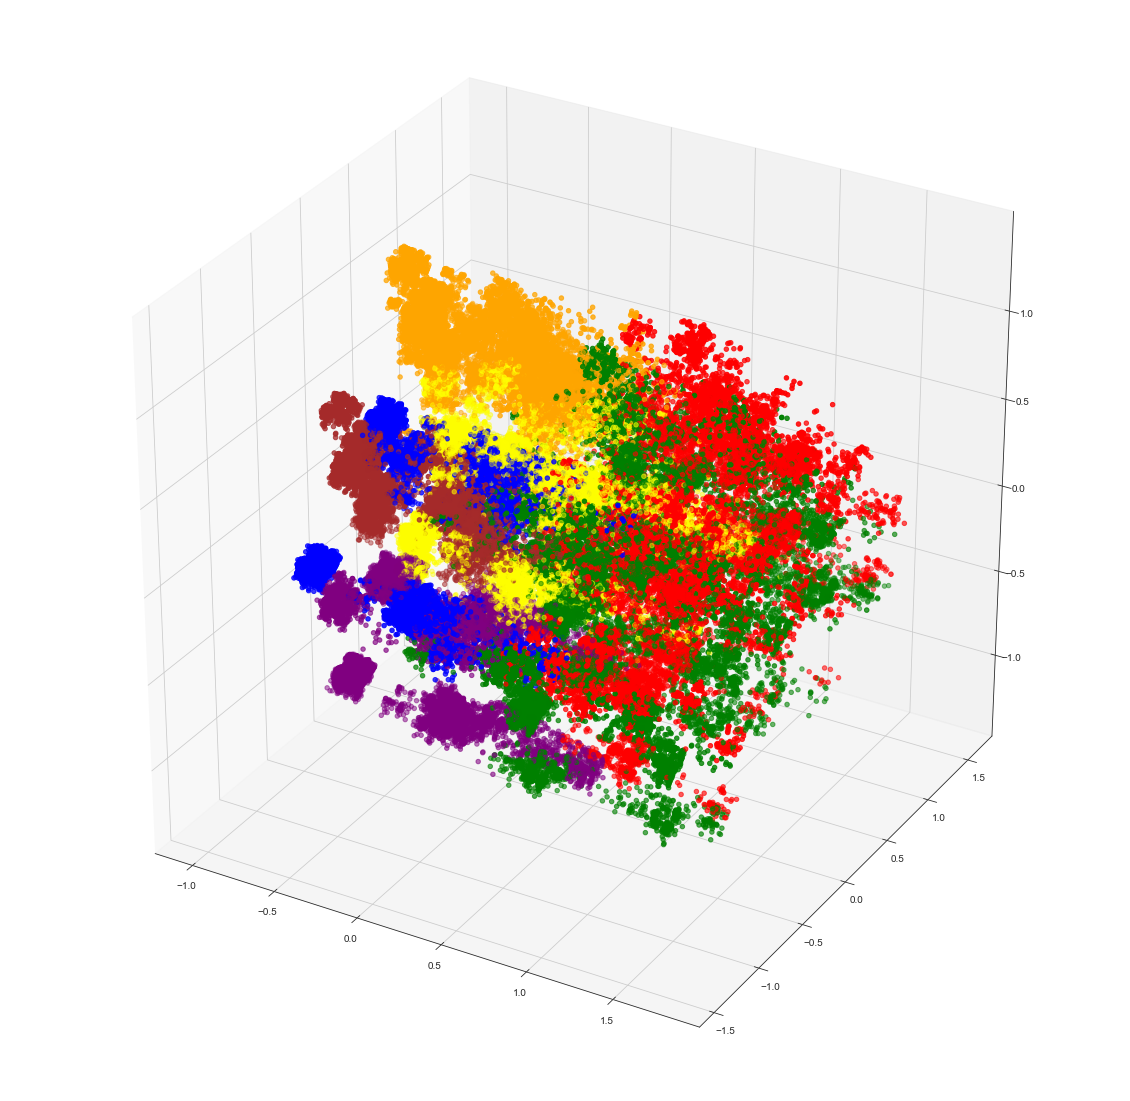

In [124]:
#cluster = df[['Speed_limit','Number_of_Vehicles','Weather_Conditions', 'Road_Surface_Conditions','Age_Band_of_Driver','Driver_Home_Area_Type']]

cluster = df_scaled
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(cluster)
pca_samples = pca.transform(cluster)

ps = pd.DataFrame(pca_samples)


clusterer = KMeans(n_clusters=7,random_state=42).fit(ps)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(ps)



colors = ['orange','blue','purple','green','red','yellow','brown','teal']
colored = [colors[k] for k in c_preds]


from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(20,20))

ax = plt.axes(projection="3d")


ax.scatter3D(ps[0], ps[1], ps[2], c=colored);
#plt.savefig("kmeans_.png")
#plt.savefig("kmeans_.svg")
plt.show()

#print(silhouette_score(ps, clusterer.labels_))

In [133]:

cluster = df_scaled
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(cluster)
pca_samples = pca.transform(cluster)

ps = pd.DataFrame(pca_samples)


clusterer = KMeans(n_clusters=7,random_state=42).fit(ps)

print(silhouette_score(ps, clusterer.labels_))

0.258143994331317


MemoryError: 

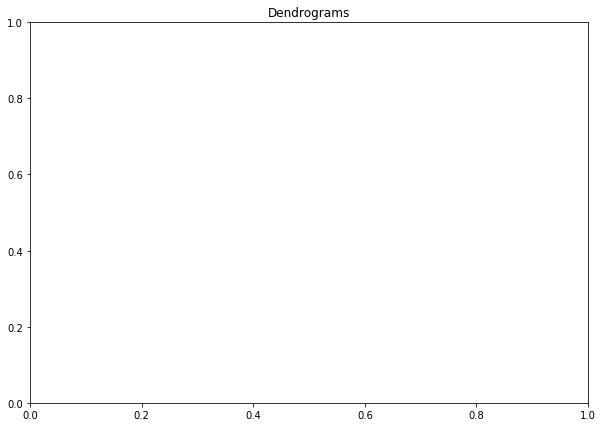

In [10]:
data = df[['Speed_limit','Number_of_Vehicles','Weather_Conditions', 'Road_Surface_Conditions','Age_Band_of_Driver','Driver_Home_Area_Type']]

rows = data.sample(frac =.01)

from sklearn.preprocessing import normalize
data_scaled = normalize(rows)
data_scaled = pd.DataFrame(data_scaled, columns=rows.columns)

import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))


In [137]:
#df_c.to_csv('custom.csv')

# DBSCAN

In [156]:
df_no = pd.read_csv('prep2minmax.csv')

df_f =  pd.read_csv('prep3.csv')

df_nof = pd.read_csv('fullflagprep.csv')

df_c = df_no[['Speed_limit','Number_of_Vehicles','Weather_Conditions', 'Road_Surface_Conditions','Age_Band_of_Driver','Driver_Home_Area_Type','Vehicle_Type']]

In [157]:
df_f = df_f.iloc[:,1:]
df_no = df_no.iloc[:,1:]
df_nof = df_nof.iloc[:,1:]
#df_c = df_no[['Number_of_Vehicles','Weather_Conditions', 'Road_Surface_Conditions','Age_Band_of_Driver','Driver_Home_Area_Type','Vehicle_Type']]

In [95]:
####################################################################################################
#da se ne bi puno ponavljao kod u ovom delu samo za df_scaled menjamo izmedju 4 gore-navedena skupa
####################################################################################################

df_scaled = df_c

#prevelik dataset #BIGDATA haha
df_scaled = df_scaled.sample(frac =.1)
df_scaled.head()
df_scaled.shape

(108825, 7)

In [96]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
principal_components = pca.fit_transform(df_scaled)
print(pca.explained_variance_)
df_pca = pd.DataFrame(principal_components, columns=['pca1', 'pca2', 'pca3', 'pca4', 
                                                     'pca5', 'pca6'])
df_pca.head()


[0.11198512 0.04424004 0.04022448 0.02792696 0.01692797 0.00771532]


,pca1,pca2,pca3,pca4,pca5,pca6
0,0.911986,-0.000189,0.161562,-0.133058,0.007535,0.019497
1,0.780745,0.438473,-0.182726,0.280284,-0.052451,0.063438
2,-0.178153,0.022710,-0.100104,-0.091063,0.182706,0.010310
3,-0.095722,-0.072651,0.234465,-0.025426,0.016946,0.121048
4,-0.187501,0.330761,0.046464,0.368447,-0.030247,0.166130


In [ ]:
from sklearn.cluster import DBSCAN

est_dbscan = DBSCAN(eps=0.3, min_samples=2)
est_dbscan.fit(df_pca)
        
print(max(est_dbscan.labels_))
#print(silhouette_score(df_scaled, est_dbscan.labels_))

In [ ]:
#######################################
# Sledece dve celije sa plotovima daju IndexError zbog broja boja, ali svakako se dobro iscrtaju klasteri
#######################################

IndexError: list index out of range

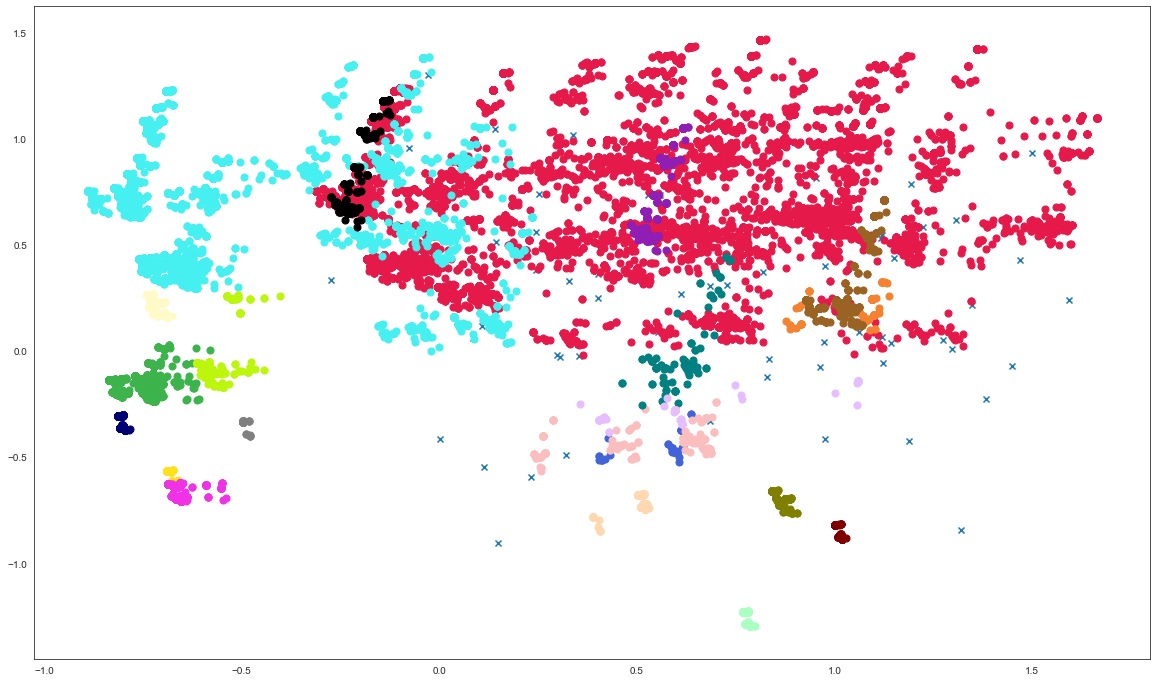

In [182]:
# 2D



fig = plt.figure(figsize=(20,12))
#colors = ['Red', 'Green', 'Blue', 'Yellow', 'Pink', 'Black', 'Purple', 'Orange', 'Grey']


colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'] 
df_pca['Labels'] = est_dbscan.labels_
for j in range(-1, max(est_dbscan.labels_)):
    if j == -1:
        noise = df_pca[df_pca['Labels'] == -1]
        plt.scatter(noise['pca1'], noise['pca2'], marker='x')
    else:
        cluster = df_pca[df_pca['Labels'] == j]
        plt.scatter(cluster['pca1'], cluster['pca2'], color=colors[j], s=50)
        
        
        
        
        


In [ ]:
# 3D

from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(20,12))
ax = plt.axes(projection="3d")
#colors = ['Red', 'Green', 'Blue', 'Yellow', 'Pink', 'Black', 'Purple', 'Orange', 'Grey']


colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'] 
df_pca['Labels'] = est_dbscan.labels_
for j in range(-1, max(est_dbscan.labels_)):
    if j == -1:
        noise = df_pca[df_pca['Labels'] == -1]
        ax.scatter3D(noise['pca1'], noise['pca2'],noise['pca3'], marker='x',s=50)
    else:
        cluster = df_pca[df_pca['Labels'] == j]
        ax.scatter3D(cluster['pca1'], cluster['pca2'],cluster['pca3'], c=colors[j],s=50)
#plt.savefig("dbscan_c.png")
#plt.savefig("dbscan_c.svg")        
plt.show()

In [2]:
################################

################################

# Hijerarhijsko

### Vazna napomena: sledeci python kodovi za hijerarhisko klasterovanje nisu mogli da mi se izvrse zbog  'MemoryError'-a pa sam ga izvrsavao u kaggle notebooku i preko njega sam dobio rezultate prikazane u seminarskom radu


In [ ]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
import numpy
import seaborn as sns


from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from scipy.cluster.vq import kmeans, vq
import scipy.cluster.hierarchy as hca

import warnings
warnings.filterwarnings("ignore")



df_no = pd.read_csv('prep2minmax.csv')

df_f =  pd.read_csv('prep3.csv')

df_nof = pd.read_csv('fullflagprep.csv')

df_c = pd.read_csv('custom.csv')


data = df_no[['Speed_limit','Number_of_Vehicles','Weather_Conditions', 'Road_Surface_Conditions','Age_Band_of_Driver','Driver_Home_Area_Type']]


In [ ]:
df_f = df_f.iloc[:,1:]
df_no = df_no.iloc[:,1:]
df_nof = df_nof.iloc[:,1:]

In [ ]:
rows = df_nof.sample(frac =.01)
data_scaled = rows
#from sklearn.preprocessing import normalize
#data_scaled = normalize(rows)
#data_scaled = pd.DataFrame(data_scaled, columns=rows.columns)

import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))

In [ ]:
df_scaled = df_nof.sample(frac =.01)
df_scaled.head()

In [ ]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'] 
from sklearn.cluster import AgglomerativeClustering



fig = plt.figure(figsize=(20,20))
plt_ind=1

from sklearn.decomposition import PCA
pca = PCA(n_components=6)
principal_components = pca.fit_transform(df_scaled)

df_pca = pd.DataFrame(principal_components, columns=['pca1', 'pca2', 'pca3', 'pca4', 
                                                     'pca5', 'pca6'])



for link in ['complete', 'average', 'single','ward']:
    for aff in [ 'manhattan', 'cosine','euclidean']:
        if link == 'ward' and aff != 'euclidean':
            continue        
        
        
        est = AgglomerativeClustering(n_clusters=10, linkage=link, affinity = aff)
        est.fit(df_pca)
        df_pca['labels'] = est.labels_

'''        
        sp =fig.add_subplot(5,5,plt_ind)
        print(link,' / ',aff,':')
        print(silhouette_score(df_pca, est.labels_),'\n')
        
        for j in range(0,max(est.labels_)):
            cluster = df_pca.loc[df_pca['labels'] ==j]
            plt.scatter(cluster['pca1'], cluster['pca2'], color = colors[j], label ="cluster %d"%j)

        plt.title('linkage %s' % link)
        plt.legend()


        plt_ind+=1

plt.tight_layout()
plt.show()
'''

# Birch

In [2]:
df_no = pd.read_csv('prep2minmax.csv')

df_f =  pd.read_csv('prep3.csv')

df_nof = pd.read_csv('fullflagprep.csv')

df_c = df_no[['Speed_limit','Number_of_Vehicles','Weather_Conditions', 'Road_Surface_Conditions','Age_Band_of_Driver','Driver_Home_Area_Type','Vehicle_Type']]

In [3]:
df_f = df_f.iloc[:,1:]
df_no = df_no.iloc[:,1:]
df_nof = df_nof.iloc[:,1:]
#df_c = df_no[['Number_of_Vehicles','Weather_Conditions', 'Road_Surface_Conditions','Age_Band_of_Driver','Driver_Home_Area_Type','Vehicle_Type']]

In [89]:
####################################################################################################
#da se ne bi puno ponavljao kod u ovom delu samo za df_scaled menjamo izmedju 4 gore-navedena skupa
####################################################################################################

df_scaled = df_no

#prevelik dataset #BIGDATA haha
df_scaled = df_scaled.sample(frac =.1)
df_scaled.head()
df_scaled.shape

(108825, 14)

In [90]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
principal_components = pca.fit_transform(df_scaled)
print(pca.explained_variance_)
df_pca = pd.DataFrame(principal_components, columns=['pca1', 'pca2', 'pca3', 'pca4', 
                                                     'pca5', 'pca6'])
df_pca.head()


[0.21918287 0.11335597 0.10466662 0.07555253 0.05121937 0.04314998]


,pca1,pca2,pca3,pca4,pca5,pca6
0,-0.296882,-0.005574,-0.412363,0.200252,-0.021956,0.049473
1,-0.299451,-0.185994,-0.296386,-0.312978,-0.064187,0.002970
2,-0.293410,-0.039230,-0.388211,0.187096,-0.075713,0.397837
3,-0.377506,-0.257321,0.416178,0.183559,-0.039679,-0.053393
4,0.711242,-0.150730,-0.354819,-0.208697,-0.027071,-0.013080


In [91]:
import sklearn.cluster as skc

In [92]:
birch = skc.Birch(n_clusters=3, branching_factor=20)
birch.fit(df_pca)

Birch(branching_factor=20, compute_labels=True, copy=True, n_clusters=3,
   threshold=0.5)

In [93]:
df_pca['Labels'] = birch.labels_

In [69]:

print(silhouette_score(df_pca, birch.labels_))

0.3125365873636617


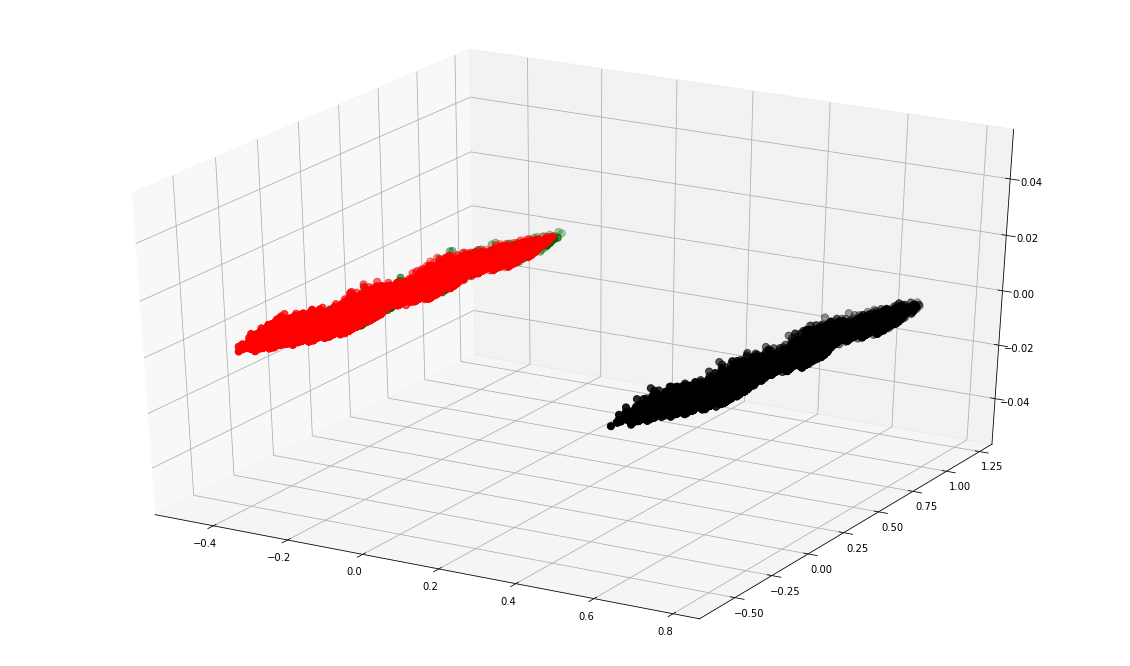

<Figure size 1440x864 with 0 Axes>

In [94]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(20,12))
ax = plt.axes(projection="3d")




colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'] 
fig = plt.figure(figsize=(20,12))
for j in range(max(birch.labels_)+1):
    cluster = df_pca[df_pca['Labels'] == j]
    ax.scatter3D(cluster['pca1'], cluster['pca2'], color=colors[j], s=50)
    
    
    
#plt.savefig("birch_c.png")
#plt.savefig("birch_c4.svg")        
plt.show()    
    
    
    
    
    
    
    
    
    # 3D

    
    

# MEAN_SHIFT
### Nije prikazan u seminarskom radu zbog problema pri izvrsavanju

In [2]:
df_no = pd.read_csv('prep2minmax.csv')

df_f =  pd.read_csv('prep3.csv')

df_nof = pd.read_csv('fullflagprep.csv')

df_c = df_no[['Speed_limit','Number_of_Vehicles','Weather_Conditions', 'Road_Surface_Conditions','Age_Band_of_Driver','Driver_Home_Area_Type','Vehicle_Type']]

In [3]:
df_f = df_f.iloc[:,1:]
df_no = df_no.iloc[:,1:]
df_nof = df_nof.iloc[:,1:]
#df_c = df_no[['Number_of_Vehicles','Weather_Conditions', 'Road_Surface_Conditions','Age_Band_of_Driver','Driver_Home_Area_Type','Vehicle_Type']]

In [4]:
####################################################################################################
#da se ne bi puno ponavljao kod u ovom delu samo za df_scaled menjamo izmedju 4 gore-navedena skupa
####################################################################################################

df_scaled = df_no

#prevelik dataset #BIGDATA haha
df_scaled = df_scaled.sample(frac =.01)
df_scaled.head()
df_scaled.shape

(54412, 14)

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
principal_components = pca.fit_transform(df_scaled)
print(pca.explained_variance_)
df_pca = pd.DataFrame(principal_components, columns=['pca1', 'pca2', 'pca3', 'pca4', 
                                                     'pca5', 'pca6'])
df_pca.head()

[0.21868662 0.114409   0.10346177 0.07539053 0.05162839 0.04261382]


,pca1,pca2,pca3,pca4,pca5,pca6
0,-0.405180,-0.288127,0.758138,0.091981,-0.012613,-0.180413
1,-0.305028,-0.097220,-0.273189,-0.111722,-0.058783,0.006365
2,0.676462,-0.272929,-0.010570,-0.086402,-0.093113,0.293141
3,-0.372125,-0.293849,0.490922,0.170062,0.043513,-0.040772
4,0.709512,-0.129421,-0.397551,-0.202209,-0.052036,-0.013629


In [6]:
import sklearn.cluster as skc

In [8]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'] 
bandwidth = skc.estimate_bandwidth(df_pca)
print(bandwidth)

0.8497825065585077


In [7]:
ms = skc.MeanShift(bandwidth=0.8, n_jobs=-1)
ms.fit(df_pca)

MeanShift(bandwidth=0.8, bin_seeding=False, cluster_all=True, min_bin_freq=1,
     n_jobs=-1, seeds=None)

In [8]:
df_pca['Labels'] = ms.labels_

In [ ]:
print(max(ms.labels_))
print(silhouette_score(df_pca, ms.labels_))

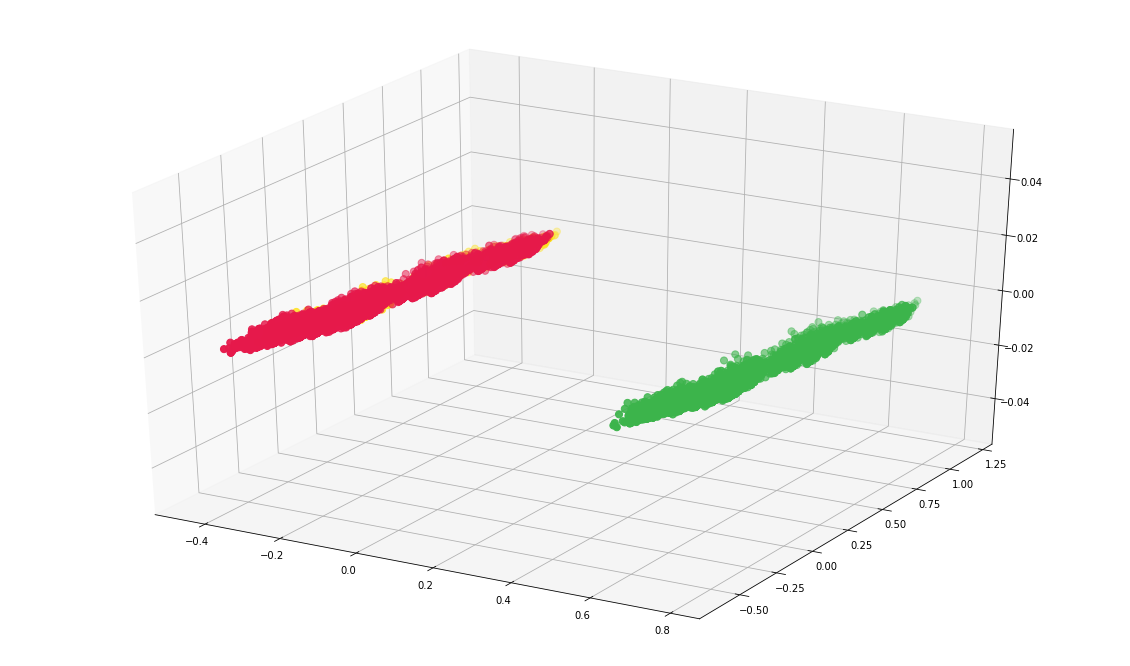

<Figure size 1440x864 with 0 Axes>

In [9]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(20,12))
ax = plt.axes(projection="3d")




colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'] 
fig = plt.figure(figsize=(20,12))
for j in range(max(ms.labels_)):
    cluster = df_pca[df_pca['Labels'] == j]
    ax.scatter3D(cluster['pca1'], cluster['pca2'], color=colors[j], s=50)
    
    
    
#plt.savefig("birch_c.png")
#plt.savefig("birch_c4.svg")        
plt.show()    
    
    
    
    
    
    
    
    
    # 3D
